# 365 DataScience Subscription Classifier 

 <img src="https://365datascience.com/resources/365-Data-Science-Open-Graph.png" />

### Before we Begin:
If you liked my work, please hit the like boutton and show me your support, because we will be ranked based on the number of likes/reactions the challenge-related post receive on LinkedIn. Thank you!

I would be pleased to receive feedback or suggestions to improve any of the below.

### Introduction
365 Data Science is an online learning platform specializing in data science courses. Students learn by watching video content, then evaluate their knowledge by taking quizzes, practice exams, course exams, and career track exams. The exams can be attempted more than once.

In this challenge, we will work on a real case and handle a classification problem that deals with a heavily imbalanced dataset.

### Our Goals
- Develop a machine learning model to predict whether a Free Plan user would convert to a paid subscriber or not.
  - Free plan user : someone who has never made an order
  - Paid subscriber : someone who has made an order at least once
- Handle the imbalanced dataset by using re-sambling methods.
- Determine the Classifiers we are going to use and decide which one has a higher f1-score, precision/recall score.

Let's start!

### Database
The dataset can be downloaded from database folder in the project repository : MySQL database of 11 tables or a collection of 11 .csv files. 


In the upcoming sections, we'll work with the following .csv files

- 365_student_info : Stores information about the students
- 365_student_purchases : Stores information about the students' subscription purchases
- 365_student_learning : Stores information about the courses a student has watched, how much of each course they have watched, and the date watched
- 365_course_info : Stores information about the courses on the platform
- 365_course_ratings : Stores information about the ratings each course has received
- 365_student_engagement : Stores information about the students' daily engagement with the platform
- 365_student_hub_questions : Stores information about the questions asked by students in the Q&A hub

### Contents :

- Importing required librairies
- Understanding our data
  - Basic insights
  - Visualizations
  - Creating new features: Extracting from existing
- Exploratory Data Analysis
  - Handling missing values
  - Visualizing relationships between features
  - Correlations
- Principal Components Analysis
  - Splitting the data into training and test sets
  - Scaling the data
  - PCA transformation
- Working with imbalanced data: Re-sampling techniques
- Modeling and evaluation
  - Selecting classification algorithms
  - Evaluating Classifiers and selecting performance metrics
  - Applying cross-validation and hyperparameter tuning techniques
- Closing thoughts

## Importing all required librairies

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

## Understanding our data

Let's load the csv files and see what we have

In [109]:
student_learning=pd.read_csv("365_student_learning.csv")

In [110]:
student_learning.head()

,student_id,course_id,minutes_watched,date_watched
0,258798,23,0.3,2022-01-01
1,258800,2,12.9,2022-04-01
2,258800,7,46.8,2022-01-03
3,258800,7,4.3,2022-01-04
4,258800,7,31.7,2022-01-07


In [111]:
len(student_learning.student_id.unique())

18167

In [112]:
student_info=pd.read_csv("365_student_info.csv")

In [113]:
student_info.head()

,student_id,student_country,date_registered
0,258798,IN,2022-01-01
1,258799,CO,2022-01-01
2,258800,CA,2022-01-01
3,258801,IN,2022-01-01
4,258802,US,2022-01-01


In [114]:
len(student_info.student_id.unique())

35230

In [115]:
student_engagement=pd.read_csv("365_student_engagement.csv")

In [116]:
student_engagement.head()

,engagement_id,student_id,engagement_quizzes,engagement_exams,engagement_lessons,date_engaged
0,1,274999,1,1,1,2022-05-27
1,3,274501,0,0,1,2022-05-27
2,4,272842,1,1,1,2022-05-27
3,8,275173,0,0,1,2022-05-27
4,11,274876,0,1,0,2022-05-27


In [117]:
len(student_engagement.student_id.unique())

18344

In [118]:
df=student_engagement[(student_engagement.engagement_quizzes==1)&(student_engagement.engagement_lessons==1)&(student_engagement.engagement_exams==1)]
len(df.student_id.unique())

2655

In [119]:
student_purchases=pd.read_csv("365_student_purchases.csv")

In [120]:
student_purchases.head()

,purchase_id,student_id,purchase_type,date_purchased
0,15781,258800,Annual,2022-01-01
1,15786,258803,Annual,2022-01-01
2,15808,258862,Annual,2022-01-01
3,15809,258865,Annual,2022-01-01
4,15811,258878,Annual,2022-01-01


In [121]:
len(student_purchases.student_id.unique())

2135

In [122]:
course_ratings=pd.read_csv("365_course_ratings.csv")

In [123]:
course_ratings.head()

,course_id,student_id,course_rating,date_rated
0,14,258956,5,2022-07-06
1,7,259019,5,2022-08-30
2,23,259019,4,2022-08-30
3,14,259283,5,2022-07-08
4,30,259283,5,2022-07-02


In [124]:
course_info=pd.read_csv("365_course_info.csv")

In [125]:
course_info.head()

,course_id,course_title
0,2,Introduction to Tableau
1,3,The Complete Data Visualization Course with Py...
2,4,Introduction to R Programming
3,5,Data Preprocessing with NumPy
4,7,Introduction to Data and Data Science


### Basic insights

After a quick look at the datasets, we can come up with the following observations :
1. Number of students who registered to 365 Data Science website is **35230**
2. Number of students who started watching courses is **18167**
3. Number of students who are engaged is **18344** divided as following :
 - 14002 with lessons
 - 151 with quizzes
 - 549 with exams
 - 2655 with all
4. Number of students who purchased one course or more is **2135**

Now, we need to merge the chosen datasets in order to come up with more informative insights

In [126]:
df = pd.merge(student_learning, student_info, how='left', on='student_id').merge(student_purchases, how='left', on='student_id').merge(course_ratings, how='left', on=['student_id', 'course_id']).merge(course_info, how='left', on='course_id')

In [127]:
df.head()

,student_id,course_id,minutes_watched,date_watched,student_country,date_registered,purchase_id,purchase_type,date_purchased,course_rating,date_rated,course_title
0,258798,23,0.3,2022-01-01,IN,2022-01-01,NaN,NaN,NaN,NaN,NaN,Introduction to Excel
1,258800,2,12.9,2022-04-01,CA,2022-01-01,15781.0,Annual,2022-01-01,NaN,NaN,Introduction to Tableau
2,258800,7,46.8,2022-01-03,CA,2022-01-01,15781.0,Annual,2022-01-01,NaN,NaN,Introduction to Data and Data Science
3,258800,7,4.3,2022-01-04,CA,2022-01-01,15781.0,Annual,2022-01-01,NaN,NaN,Introduction to Data and Data Science
4,258800,7,31.7,2022-01-07,CA,2022-01-01,15781.0,Annual,2022-01-01,NaN,NaN,Introduction to Data and Data Science


In [128]:
df.shape

(87633, 12)

In [129]:
df.isnull().sum()

student_id             0
course_id              0
minutes_watched        0
date_watched           0
student_country       44
date_registered        0
purchase_id        27204
purchase_type      27204
date_purchased     27204
course_rating      71054
date_rated         71054
course_title          80
dtype: int64

### Visualizations

After the merging, we got a big dataset with 12 columns and 87633 records. However, there is a lot of missing values that we will handle later on.

Now, let's plot some visualizations to get more informations about our data :
   - Donut chart to visualize the countries with the higher registered students rate
   - Histogram to have a clue on student's satisfaction and the course's quality
   - Countplot to visualize what purchase type students prefer the most

In [130]:
country_values=df['student_country'].value_counts().values

In [131]:
country_names=df['student_country'].value_counts().index

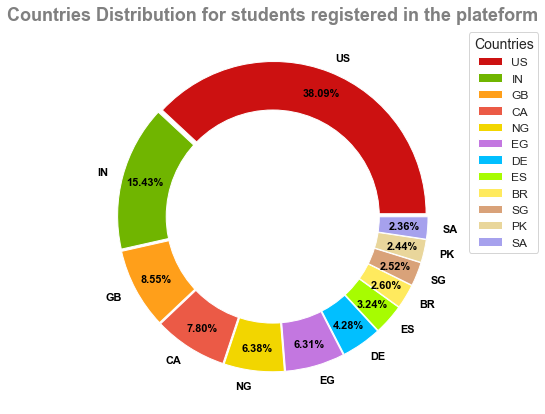

In [132]:
# Donut Chart 
fig, ax = plt.subplots(figsize =(9, 7))
myexplode = list(0.02*np.ones(12))
colors=['#CC1111','#70B500','#FF9F1A','#EB5A46','#F2D600','#C377E0','#01BFFF','#A7FC01','#FFEA5E','#D9A279','#E9D69B','#A6A1ED']
wp = { 'linewidth' : 1, 'edgecolor' : "white" }
wedges, texts, autotexts = ax.pie(country_values[:12],labels=country_names[:12],autopct='%1.2f%%',explode = myexplode,shadow=False,wedgeprops = wp,textprops = dict(color ="black"), pctdistance=0.85, colors=colors)
ax.legend(title ="Countries",
          loc ="best",
          bbox_to_anchor =(1, 0, 0, 1),
          fontsize=12,
          title_fontsize=14)
plt.setp(autotexts, size = 11, weight ="bold")
plt.setp(texts, size = 11, weight ="bold")
ax.set_title("Countries Distribution for students registered in the plateform", 
             fontdict={'fontsize':18, 'fontweight':'bold','color': 'grey'}, loc='center')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.savefig('Countries Distribution')

We can clearly see that one-fourth (38.09%) of students are from United States with next time being from India then United Kingdom and so forth

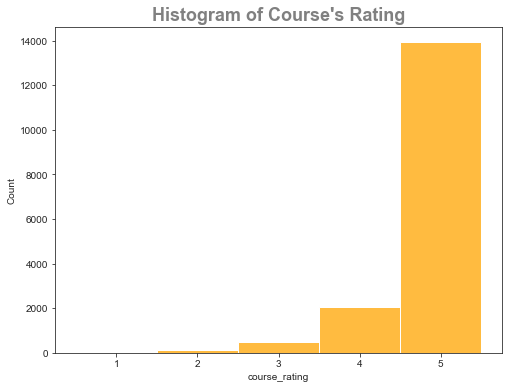

In [133]:
# Histogram
sns.set_style('ticks')
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='course_rating', discrete=True, color='orange')
plt.title("Histogram of Course's Rating", fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig("Histogram of Course's Rating")

We observe that the majority of courses have a very high rating (5 stars) which means that many courses exceed student's expectations
- 4 stars : course meet student's expectations
- 5 stars : course exceed student's expectations

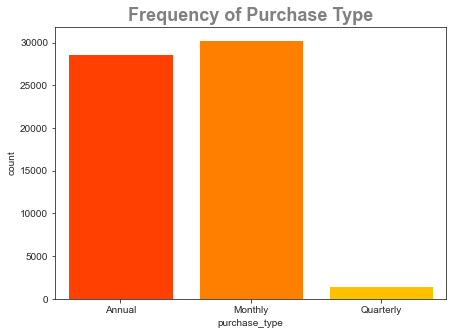

In [134]:
# Countplot
sns.set_style('ticks')
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='purchase_type', palette='autumn', saturation=1)
plt.title("Frequency of Purchase Type", fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.show()

We notice that the majority of students opt for both monthly and annual purchase 

### Creating new features: Extracting from existing¶

To go further, we need to consider the features that could be used as a defining difference between users who are likely to subscribe and those who are not. Therfore, we have to extract new features from the existing ones. 

This task can be done easily using SQL programming language but we'll go for the hard way and we'll use groupby function to group by the student id and create some relevant features :

1. Independant variables :
  - ***total_minutes_watched*** --> Minutes watched on the platform per student (numeric)
  - ***total_courses_enrolled*** --> Number of enrolled courses per student (numeric)
  - ***engagement_days*** --> Number of days in which a student was engaged (numeric)
  - ***engaged_with_courses*** --> Engagement with courses (binary: “1”, means “engaged”, “0” means “not engaged”)
  - ***engaged_with_quizzes*** --> Engagement with quizzes (binary: “1”, means “engaged”, “0” means “not engaged”)
  - ***engaged_with_exams*** --> Engagement with exams (binary: “1”, means “engaged”, “0” means “not engaged”)
  - ***engaged_with_Q&A*** --> Engagement in the Q&A hub (binary: “1”, means “engaged”, “0” means “not engaged”)


2. Dependant variable (desired target) :
  - ***subscribed*** --> has the student subscribed or not? (binary: “1”, means “Yes”, “0” means “No”)



Let's start with creating total minutes watched feature. To do so, we'll group students by student id and then sum up all minutes watched on the platform for each student by using the sum aggregate

In [135]:
# Total minutes watched per student
minutes_watched = df.groupby('student_id')['minutes_watched'].sum('minutes_watched').reset_index().rename({'minutes_watched':'total_minutes_watched'},axis=1)
minutes_watched

,student_id,total_minutes_watched
0,258798,0.3
1,258800,531.2
2,258803,620.0
3,258804,14.2
4,258807,1.8
...,...,...
18162,295509,0.8
18163,295510,0.1
18164,295511,7.8
18165,295512,10.4


Next, we'll create number of courses enrolled feature. We start by grouping students as we have done above but this time we'll use nunique aggregate. It counts unique courses for each student

In [136]:
# Number of courses enrolled per student
courses_enrolled = df.groupby(by='student_id', as_index=False).agg({'course_title': pd.Series.nunique}).rename({'course_title':'total_courses_enrolled'},axis=1)
courses_enrolled

,student_id,total_courses_enrolled
0,258798,1
1,258800,9
2,258803,3
3,258804,1
4,258807,1
...,...,...
18162,295509,1
18163,295510,1
18164,295511,1
18165,295512,1


Now, we'll create the third feature : number of engagement days. This time, we can proceed similarly to the previous feature by using nunique that counts unique engaged dates for each student

In [137]:
df2=pd.merge(df,student_engagement,how='left',on='student_id')
#df2.head()

In [138]:
# Number of engagement days per student
engagement_days = df2.groupby(by='student_id', as_index=False).agg({'date_engaged': pd.Series.nunique}).rename({'date_engaged':'engagement_days'},axis=1)
engagement_days

,student_id,engagement_days
0,258798,1
1,258800,29
2,258803,19
3,258804,1
4,258807,1
...,...,...
18162,295509,1
18163,295510,1
18164,295511,1
18165,295512,1


The fourth feature as we mentionned before is the engagement with lessons, In order to create this feature, we start as usual by grouping the students by their id but this time we'll use a different aggregate function. It's the max function that computes the maximum of group values. 

***Why max ?***

"engagement_lessons" is a binary variable (0/1) : “1”, means “engaged”, “0” means “not engaged”. To conclude that a student is engaged with lessons we only need to be sure that he was engaged at least with one course.

- max(1, 0, 0, 1) = 1
- max(0, 0, 0, 0) = 0

In [139]:
# Engagement with lessons
engagement_lesson=df2.groupby(by=['student_id'], as_index=False).agg({'engagement_lessons': pd.Series.max}).rename({'engagement_lessons':'engaged_with_lessons'},axis=1)
engagement_lesson

,student_id,engaged_with_lessons
0,258798,1.0
1,258800,1.0
2,258803,1.0
3,258804,1.0
4,258807,1.0
...,...,...
18162,295509,1.0
18163,295510,1.0
18164,295511,1.0
18165,295512,1.0


In [140]:
engagement_lesson[engagement_lesson['engaged_with_lessons']==0]

,student_id,engaged_with_lessons
7457,273882,0.0


In [141]:
engagement_lesson[engagement_lesson['engaged_with_lessons']==1]

,student_id,engaged_with_lessons
0,258798,1.0
1,258800,1.0
2,258803,1.0
3,258804,1.0
4,258807,1.0
...,...,...
18162,295509,1.0
18163,295510,1.0
18164,295511,1.0
18165,295512,1.0


We remark that all the students are engaged with courses. Therfore, there is no need use this feature in the next steps

Now, we'll create the engagement with quizzes feature. Again, we'll use the max aggregate as we've done in the cell above.

In [142]:
# Engagemnt with quizzes
engagement_quiz=df2.groupby(by=['student_id'], as_index=False).agg({'engagement_quizzes': pd.Series.max}).rename({'engagement_quizzes':'engaged_with_quizzes'},axis=1)
engagement_quiz

,student_id,engaged_with_quizzes
0,258798,0.0
1,258800,1.0
2,258803,1.0
3,258804,1.0
4,258807,0.0
...,...,...
18162,295509,0.0
18163,295510,0.0
18164,295511,1.0
18165,295512,1.0


Same for the engagement with exams feature

In [143]:
# Engagement with exams
engagement_exam=df2.groupby(by=['student_id'], as_index=False).agg({'engagement_exams': pd.Series.max}).rename({'engagement_exams':'engaged_with_exams'},axis=1)
engagement_exam

,student_id,engaged_with_exams
0,258798,0.0
1,258800,1.0
2,258803,1.0
3,258804,0.0
4,258807,0.0
...,...,...
18162,295509,0.0
18163,295510,0.0
18164,295511,0.0
18165,295512,0.0


This time, we'll create our last dependant feature : engagement with Q&A hub. As usual, we begin with grouping all the students by their id. Next, we use the nunique function that counts unique questions asked by each student and returns the number of questions that each student has asked. This number equals one of the following values [0, 1, 2, 3+].

But, we aim to create a binary variable (0/1) : “1”, means “engaged”, “0” means “not engaged”. To conclude that a student is engaged with the Q&A hub we only need to be sure that he asked or answered at least one question.

So we'll apply a lambda function that returns 1 whenever the number of questions asked by a student is geater than 1.

In [144]:
student_hub_questions = pd.read_csv("365_student_hub_questions.csv")

In [145]:
df3 = df.merge(student_hub_questions, how='left', on = 'student_id')

In [146]:
# Engagement with Q&A hub
engagement_QA = df3.groupby('student_id')['hub_question_id'].nunique().apply(lambda x: 1 if x>0 else x).reset_index().rename({'hub_question_id':'engaged_with_Q&A'}, axis=1)
engagement_QA

,student_id,engaged_with_Q&A
0,258798,0
1,258800,0
2,258803,1
3,258804,0
4,258807,0
...,...,...
18162,295509,0
18163,295510,0
18164,295511,0
18165,295512,0


In [147]:
engagement_QA[engagement_QA['engaged_with_Q&A']==0]

,student_id,engaged_with_Q&A
0,258798,0
1,258800,0
3,258804,0
4,258807,0
5,258809,0
...,...,...
18162,295509,0
18163,295510,0
18164,295511,0
18165,295512,0


In [148]:
engagement_QA['engaged_with_Q&A'].unique()

array([0, 1], dtype=int64)

Now it's time to create our target variable : subscribed. First we begin with grouping all the students by their id. Then, we use the nunique function that counts unique purchase type for each student. 

"purchase_type" is a categorical variable ("Monthly", "Annual", "Quartely"). So nunique returns one of the following values 
[0, 1, 2, 3].

But, we aim to create a binary variable (0/1) : “1”, means “subscribed”, “0” means “not subscribed”. To conclude that a student is subscribed we only need to be sure that he purchased at least one type.

So we'll apply a lambda function that returns 1 whenever the number of purchases done by a student is geater than 1.

In [149]:
subscription=df.groupby('student_id')['purchase_type'].nunique().apply(lambda x: 1 if x>0 else x).reset_index().rename({'purchase_type':'subscribed'}, axis=1)
subscription

,student_id,subscribed
0,258798,0
1,258800,1
2,258803,1
3,258804,0
4,258807,0
...,...,...
18162,295509,0
18163,295510,0
18164,295511,0
18165,295512,0


In [150]:
subscription[subscription['subscribed']==1].shape

(2027, 2)

In [151]:
subscription[subscription['subscribed']==0]

,student_id,subscribed
0,258798,0
3,258804,0
4,258807,0
5,258809,0
6,258810,0
...,...,...
18162,295509,0
18163,295510,0
18164,295511,0
18165,295512,0


In [152]:
subscription['subscribed'].unique()

array([0, 1], dtype=int64)

Let's merge all the features into one dataset in order tp apply any preprocessing needed

In [153]:
df_final = pd.merge(minutes_watched, courses_enrolled, how='left', on='student_id').merge(engagement_days, how='left', on='student_id').merge(engagement_quiz, how='left', on='student_id').merge(engagement_exam, how='left', on='student_id').merge(engagement_QA, how='left', on='student_id').merge(subscription, how='left', on='student_id')

In [154]:
df_final.head()

,student_id,total_minutes_watched,total_courses_enrolled,engagement_days,engaged_with_quizzes,engaged_with_exams,engaged_with_Q&A,subscribed
0,258798,0.3,1,1,0.0,0.0,0,0
1,258800,531.2,9,29,1.0,1.0,0,1
2,258803,620.0,3,19,1.0,1.0,1,1
3,258804,14.2,1,1,1.0,0.0,0,0
4,258807,1.8,1,1,0.0,0.0,0,0


In [155]:
df_final.shape

(18167, 8)

Our final dataset includes 8 columns and 18167 records 

## Exploratory Data Analysis (EDA)

### Handling missing values

Let's check if there is any missing values in our dataset

In [156]:
# count missing values
df_final.isnull().sum()

student_id                0
total_minutes_watched     0
total_courses_enrolled    0
engagement_days           0
engaged_with_quizzes      3
engaged_with_exams        3
engaged_with_Q&A          0
subscribed                0
dtype: int64

Luckily, We have small number of missing values (3 << 18167). So we can drop those observations using dropna function

In [157]:
# drop missing values using dropna function
df_final.dropna(subset=['engaged_with_quizzes', 'engaged_with_exams'], inplace=True)
df_final.isnull().sum()

student_id                0
total_minutes_watched     0
total_courses_enrolled    0
engagement_days           0
engaged_with_quizzes      0
engaged_with_exams        0
engaged_with_Q&A          0
subscribed                0
dtype: int64

In [158]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18164 entries, 0 to 18166
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              18164 non-null  int64  
 1   total_minutes_watched   18164 non-null  float64
 2   total_courses_enrolled  18164 non-null  int64  
 3   engagement_days         18164 non-null  int64  
 4   engaged_with_quizzes    18164 non-null  float64
 5   engaged_with_exams      18164 non-null  float64
 6   engaged_with_Q&A        18164 non-null  int64  
 7   subscribed              18164 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.2 MB


ALL features are numerical which is great. Now, let's take a look at our target variable

In [159]:
df_final['subscribed'].value_counts()

0    16137
1     2027
Name: subscribed, dtype: int64

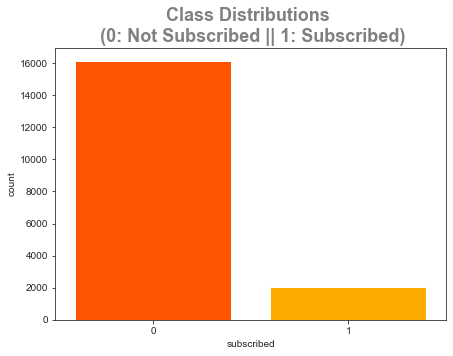

In [160]:
sns.set_style('ticks')
plt.figure(figsize=(7,5))
sns.countplot(data=df_final, x='subscribed', palette='autumn', saturation=1)
plt.title("Class Distributions \n (0: Not Subscribed || 1: Subscribed)", fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('before re-sampling imbalanced classes')

In [161]:
not_sub = len(df_final[df_final['subscribed']==0])
sub = len(df_final[df_final['subscribed']==1])
pct_not_sub = not_sub/(not_sub+sub)
print("Percentage of subscribed students : ", round(pct_not_sub*100, 2))
pct_sub = sub/(not_sub+sub)
print("Percentage of not subscribed students : ", round(pct_sub*100, 2))

Percentage of subscribed students :  88.84
Percentage of not subscribed students :  11.16


Our classes are imbalanced. Most of the students were not subscribed (88.84%) of the time, while subscribed students occur (11.16%) of the time in the dataframe.

Before we go ahead to balance the classes, let’s do some more exploration

### Visualizing relationships between features

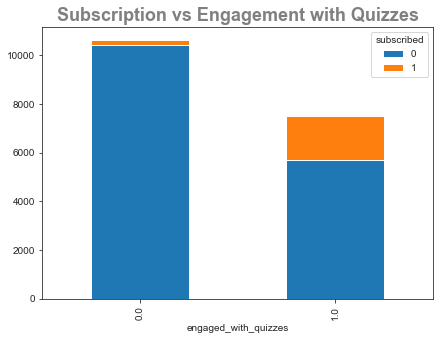

In [162]:
# subscription vs engagement with quizzes
plt.rcParams["figure.figsize"] = (7, 5)
pd.crosstab(df_final['engaged_with_quizzes'],df_final['subscribed']).plot.bar(stacked=True)
plt.title('Subscription vs Engagement with Quizzes', fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('subscription vs engagement with quizze')

Student's  engagement with quizzes seems to be a good predictor for the outcome variable

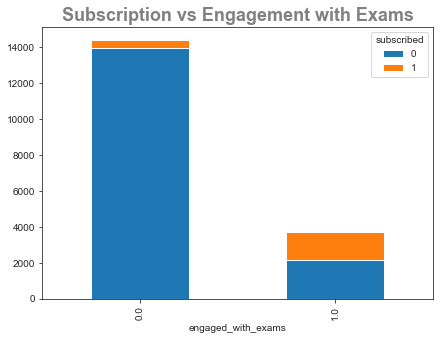

In [163]:
# subscription vs engagement with exams
pd.crosstab(df_final['engaged_with_exams'],df_final['subscribed']).plot.bar(stacked=True)
plt.title('Subscription vs Engagement with Exams', fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('subscription vs engagement with exams')

Student's engagement with exams can be a good predictor of the outcome variable.

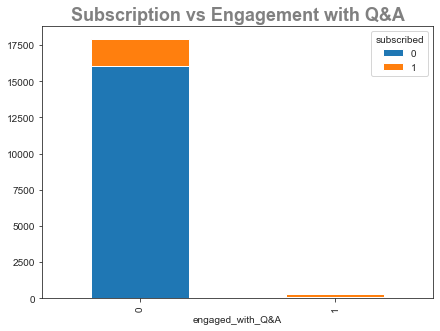

In [164]:
#subscription vs engagement with Q&A
pd.crosstab(df_final['engaged_with_Q&A'],df_final['subscribed']).plot.bar(stacked=True)
plt.title('Subscription vs Engagement with Q&A', fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('subscription vs engagement with Q&A')

Student's engagement with the Q&A hub might not be a good predictor of the outcome variable.

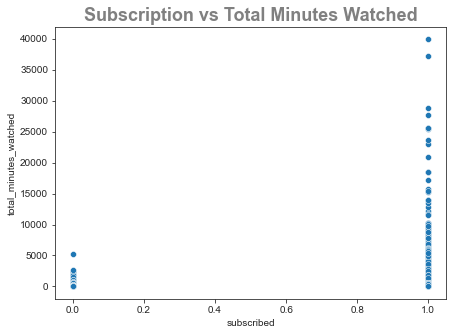

In [165]:
# subscription vs total_minutes_watched
sns.scatterplot(data=df_final,x='subscribed',y='total_minutes_watched')
plt.title('Subscription vs Total Minutes Watched', fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('subscription vs total minutes watched')

Total minutes watched per student depends heavily on student's subscription. So total minutes watched might be a good estimator for the outcome variable.

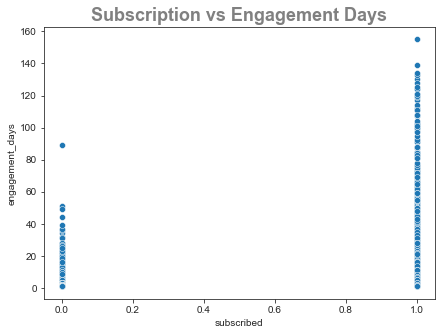

In [166]:
# subscription vs engagement_days
sns.scatterplot(data=df_final,x='subscribed',y='engagement_days')
plt.title('Subscription vs Engagement Days', fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('subscription vs engagement days')

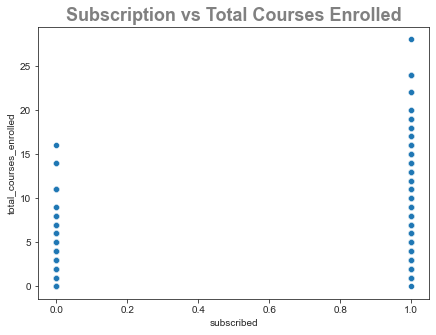

In [167]:
# subscription vs total_courses_enrolled
sns.scatterplot(data=df_final,x='subscribed',y='total_courses_enrolled')
plt.title('Subscription vs Total Courses Enrolled', fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('subscription vs total courses enrolled')

Same thing goes with the number of days in wich a student was engaged and the number of courses enrolled per student.

### Correlations

Now let's visualize correlations between features 
 - Correlations between numerical variables
 - Correlations between target and indepandant features

In [168]:
# correlation matrix
corr_matrix=df_final.drop('student_id', axis=1).corr()

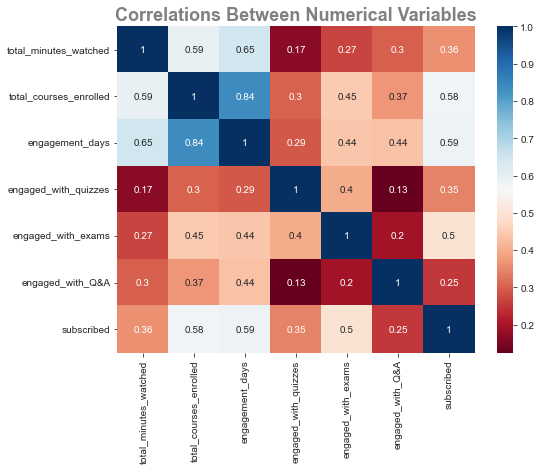

In [169]:
# correlations between numerical variables
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix,cbar=True,annot=True,cmap='RdBu')
plt.title("Correlations Between Numerical Variables",fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('Correlations')

In [170]:
# correlations between target and indepandant features
corr_matrix['subscribed'].sort_values(ascending=False).round(2)

subscribed                1.00
engagement_days           0.59
total_courses_enrolled    0.58
engaged_with_exams        0.50
total_minutes_watched     0.36
engaged_with_quizzes      0.35
engaged_with_Q&A          0.25
Name: subscribed, dtype: float64

Observations :
 - Multicolinearity exists, there are high correlations between some predictor variables.
 - All independant features are positively correlated to the target variable.
 - There is a strong correlation between "engagement_days", "total_courses_enrolled" and the outcome variable.

In [171]:
numerical_variables = df_final.columns.tolist()
numerical_variables.remove('student_id')
numerical_variables.remove('subscribed')
numerical_variables

['total_minutes_watched',
 'total_courses_enrolled',
 'engagement_days',
 'engaged_with_quizzes',
 'engaged_with_exams',
 'engaged_with_Q&A']

Let's find out if correlations are statistically significant using p-value of Pearson coefficient

In [172]:
def p_value_pearson_coef(df,Y):
    for col in df[numerical_variables]:
        result = stats.pearsonr(df[col], df[Y])
        print(col)
        print(result)

In [173]:
p_value_pearson_coef(df_final,'subscribed')

total_minutes_watched
PearsonRResult(statistic=0.3627247459522953, pvalue=0.0)
total_courses_enrolled
PearsonRResult(statistic=0.5792509535105388, pvalue=0.0)
engagement_days
PearsonRResult(statistic=0.588081976016594, pvalue=0.0)
engaged_with_quizzes
PearsonRResult(statistic=0.3462910268305746, pvalue=0.0)
engaged_with_exams
PearsonRResult(statistic=0.4981601220126326, pvalue=0.0)
engaged_with_Q&A
PearsonRResult(statistic=0.2532925471240121, pvalue=7.282965627080299e-264)


All p-values are lower than 5% (pvalue=0.0 << 5%). So correlation coefficients between indepandent variables and the target are statistically significant 

Now, we have to handle multicolinearity. To do so, we'll use PCA technique

## Principal Component Analysis (PCA) 

In order to minimize the correlation between different features and reduce the feature space, we'll use PCA technique.

PCA is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features while still retaining most of the information.

Before implementing the PCA transformation, we should split our data into train and test sets and separate the features from the labels.

***Why?***  For testing purposes.

### Splitting the data into training and test sets

In [174]:
data=df_final.copy()

In [175]:
# separate out the features
X = data.drop(['subscribed','student_id'], axis=1)

# separate out the target
y = data['subscribed']

To ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set, we do a single stratified sampling based on the target variable while splitting the data

In [176]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

### Scaling the data

In order to implement a PCA transformation features need to be previously scaled. We'll use StandardScaler to standardize the dataset’s features into unit scale (mean = 0 and variance = 1) 

In [177]:
# fit scaler on training data
scaler = StandardScaler().fit(X_train)

# transform training data
X_train = scaler.transform(X_train)

# transform testing data
X_test = scaler.transform(X_test)

### PCA transformation

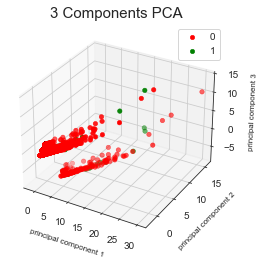

In [178]:
# 3 Principal Components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data=principal_components, 
                            columns=['principal component 1', 'principal component 2', 'principal component 3'])
pca_final_df= pd.concat([principal_df, y_train], axis=1)   
pca_final_df.head()
targets = [0, 1]
colors = ['r', 'g']
my_dpi = 96
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('principal component 1',fontsize=8)
ax.set_ylabel('principal component 2',fontsize=8)
ax.set_zlabel('principal component 3',fontsize=8)
ax.set_title('3 Components PCA',fontsize=15)
for target, color in zip(targets,colors):
    indicesToKeep = pca_final_df['subscribed'] == target
    ax.scatter(pca_final_df.loc[indicesToKeep, 'principal component 1'],
              pca_final_df.loc[indicesToKeep, 'principal component 2'],
              pca_final_df.loc[indicesToKeep, 'principal component 3'],
              c=color, linewidth=0.5)
ax.legend(targets)
plt.savefig('3 Components PCA')

In [179]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [180]:
# 3 PCA
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.51, 0.17, 0.12])

It's obvious that the first principal component is responsible for 51% variance. Similarly, the second principal component causes 17% variance in the dataset and the third one is responsible for 12% variance. So we can say that (0.51+0.17+0.12) 80% percent of the classification information contained in the feature set is captured by the first three principal components.

## Working with imbalanced data: Re-sampling techniques

After handling the multicolinearity, it's time to handle the imbalance of the data.

To do this, we'll implement an Over-Sampling technique called SMOTE (Synthetic Minority Oversampling Technique)
 - Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies
 - Randomly choosing one of the k-nearest-neighbors and using it to create a similar new observations


In [181]:
os = SMOTE(random_state=0)
X_train_os, y_train_os = os.fit_resample(X_train, y_train)

C:\Users\joukre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


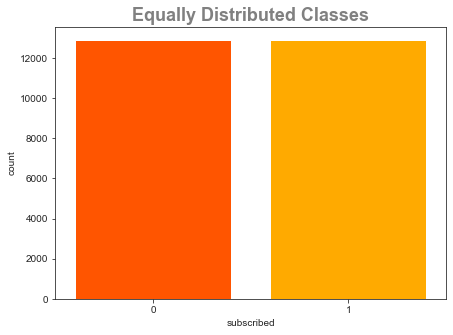

In [182]:
sns.set_style('ticks')
plt.figure(figsize=(7,5))
sns.countplot(y_train_os, palette='autumn', saturation=1)
plt.title("Equally Distributed Classes", fontdict={'fontsize':18,'fontweight':'bold','color': 'grey'}, loc='center')
plt.savefig('after re-sampling imbalanced classes')

Now we have a perfect balanced data. We applied the over-sampling only to the training dataset because the test dataset is reserved for testing the model’s performance on data that the model has never encountered

## Modeling 

### Selecting classification algorithms

In this section we will train many types of classifiers and decide which classifier will be more effective in predicting whether a Free Plan user would convert to a paid subscriber or not

In [183]:
from sklearn.linear_model import SGDClassifier

In [184]:
Classifiers = {'LogisticRegression': LogisticRegression(),
               'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=4),
                'DecisionTreeClassifier': DecisionTreeClassifier(),
                'RandomForestClassifier': RandomForestClassifier(),
                'GaussianNB': GaussianNB(),
                'SupportVectorMachine': SVC(),
                'XGBClassifier': XGBClassifier(objective="binary:logistic"),
                'MLPClassifier': MLPClassifier(),
                'SGDClassifier': SGDClassifier(),
                'GradientBoostingClassifier': GradientBoostingClassifier()

}

In [185]:
scores = []
predictions = []
for name, classifier in Classifiers.items():
    classifier.fit(X_train_os, y_train_os)
    y_pred = classifier.predict(X_test)
    predictions.append(y_pred)
    scores.append({
        'Classifier': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Roc score': roc_auc_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1 score': f1_score(y_test, y_pred)
    })

### Evaluating Classifiers and selecting performance metrics

There are many ways for measuring performance. For a classification problem, Confusion Matrix metrics (**accuracy/roc score/recall/presicioon/f1 score**) are widely used. 

  - Accuracy simply measures how often the classifier correctly predicts. 
  - Precision explains how many of the correctly predicted cases actually turned out to be positive.
  - Recall explains how many of the actual positive cases we were able to predict correctly with our model.
  - F1 Score gives a combined idea about Precision and Recall metrics.
  - Roc score is a probability curve that plots the TPR(True Positive Rate) against the FPR(False Positive Rate).

In our case we'll focus on the F1 metric.

***Why not Accuracy ?*** Accuracy can be be misleading it this classification problem. It is useful when the target class is well balanced but here we are dealing with a heavily unbalanced classes.

***Why F1 score ?*** The F1 score is the harmonic mean of precision and recall. It maintains a balance between the precision and recall for our classifier. 

F1 Score could be an effective evaluation metric in our case for the following reasons :
- False Positive and False Negative are equally costly in this classification problem
- True Negative is high

In [186]:
classifier_scores = pd.DataFrame(scores)
classifier_scores

,Classifier,Accuracy,Roc score,Recall,Precision,F1 score
0,LogisticRegression,0.873933,0.858879,0.839506,0.463847,0.597540
1,KNeighborsClassifier,0.888522,0.836858,0.770370,0.500000,0.606414
2,DecisionTreeClassifier,0.885494,0.822198,0.740741,0.490998,0.590551
3,RandomForestClassifier,0.887146,0.850119,0.802469,0.496183,0.613208
4,GaussianNB,0.920176,0.825520,0.703704,0.626374,0.662791
5,SupportVectorMachine,0.881365,0.860902,0.834568,0.481481,0.610659
6,XGBClassifier,0.897330,0.863408,0.819753,0.525316,0.640309
7,MLPClassifier,0.879714,0.872929,0.864198,0.478142,0.615655
8,SGDClassifier,0.916873,0.849573,0.762963,0.600000,0.671739
9,GradientBoostingClassifier,0.893201,0.879439,0.861728,0.512482,0.642726


After comparing the F1 score for all the models, it seems that the **Gaussian Naive Bayes classifier** have the higher score (**F1 = 0.66**). So GNB classifer is the best model in our case.

Let's take a look at confusion matrices for the top 4 classifiers in term of F1 score

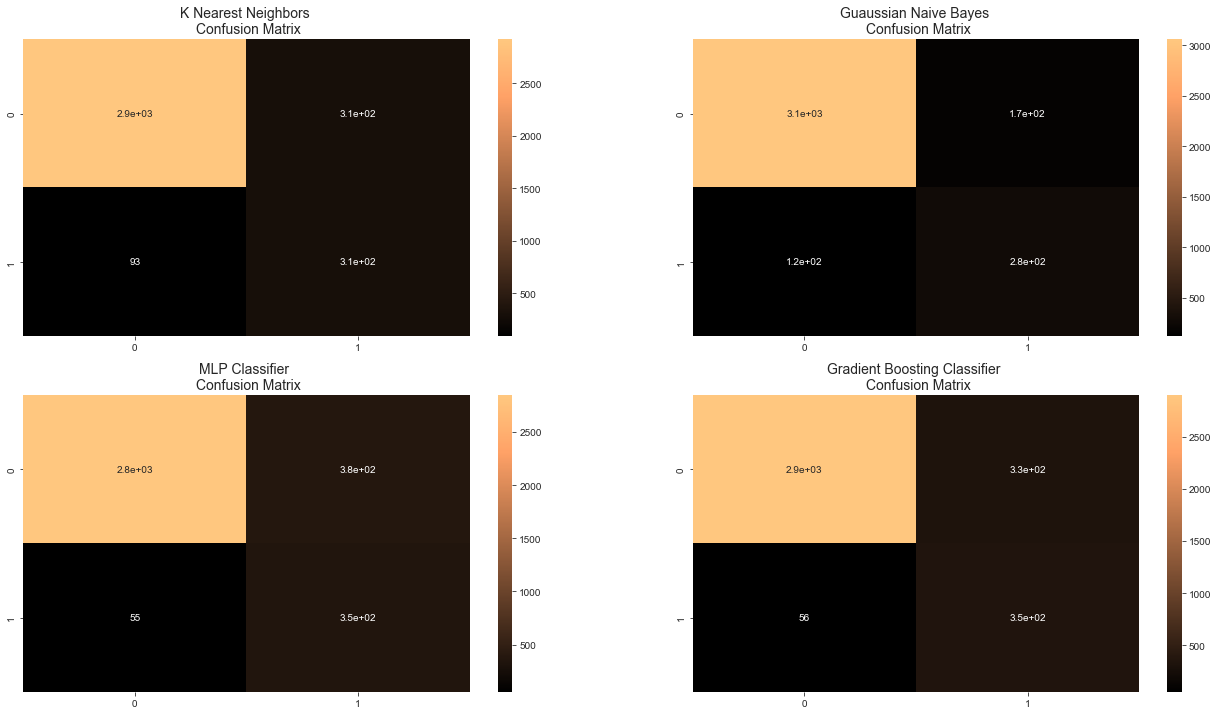

In [187]:
# Confusion matrices
cf_KNN = confusion_matrix(y_test, predictions[1])
cf_GNB = confusion_matrix(y_test, predictions[4])
cf_MLP = confusion_matrix(y_test, predictions[7])
cf_GB = confusion_matrix(y_test, predictions[9])

fig, ax = plt.subplots(2, 2,figsize=(22,12))
sns.heatmap(cf_KNN, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0][0].set_title("K Nearest Neighbors \n Confusion Matrix", fontsize=14)
sns.heatmap(cf_GNB, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("Guaussian Naive Bayes \n Confusion Matrix", fontsize=14)

sns.heatmap(cf_MLP, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("MLP Classifier \n Confusion Matrix", fontsize=14)

sns.heatmap(cf_GB, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("Gradient Boosting Classifier \n Confusion Matrix", fontsize=14)

plt.show()

LR Accuracy :  0.9201761629507295
roc score   :  0.8255197576758915
precision   :  0.6263736263736264
recall      :  0.7037037037037037
f1 score    :  0.6627906976744186


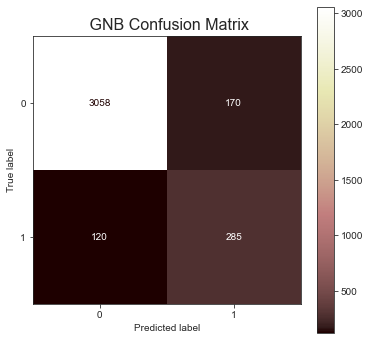

In [196]:
GNB = GaussianNB()
GNB.fit(X_train_os, y_train_os)
y_test_pred = GNB.predict(X_test)
score = accuracy_score(y_test, y_test_pred)
print("LR Accuracy : ", score)
roc = roc_auc_score(y_test, y_test_pred)
print("roc score   : ", roc)
x = precision_score(y_test, y_test_pred)
y = recall_score(y_test, y_test_pred)
z = f1_score(y_test, y_test_pred)
print("precision   : ", x)
print("recall      : ", y)
print("f1 score    : ", z)
cnf_matrix=confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(6, 6))
cm_display = ConfusionMatrixDisplay(cnf_matrix, display_labels = ['Class 0', 'Class 1'])
cm_display = ConfusionMatrixDisplay(cnf_matrix)


cm_display.plot(ax=ax, cmap=plt.cm.pink)
ax.set_title(' GNB Confusion Matrix', size=16)
plt.savefig("GaussianNB confusion matrix before hyperparameter tuning")

This is how the confusion matrix works :

- ***True Positive***: We predicted positive and it’s true. Here, we predicted that a student convert to a paid subscriber and he actually is.

- ***True Negative***: We predicted negative and it’s true.Here, we predicted that a student is not subscribed and he actually is not.

- ***False Positive (Type 1 Error)***: We predicted positive and it’s false. Here, we predicted that a student convert to a paid subscriber but he actually is not.

- ***False Negative (Type 2 Error)***: We predicted negative and it’s false. Here, we predicted that a student is not subscribed but he actually is.

### Applying cross-validation and hyperparameter tuning techniques 

For better training our model we'll apply cross-validation and hyperparameter tuning.

In order to implement cross validation technique, we should oversample our training data during cross-validation, not before!
Therfore, we'll make a pipeline that combine SMOTE method for oversampling our data and the chosen classifier with the best f1 score.

Then, we'll implement GridSearch technique for tuning classfier's hyperparameters and choose the best ones for our model. 

In [189]:
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              GaussianNB())
imba_pipeline

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('gaussiannb', GaussianNB())])

In [190]:
params = {'var_smoothing': np.logspace(0,-9, num=100)}
cross_val_score(imba_pipeline, X_train, y_train, scoring='f1', cv=3)
new_params = {'gaussiannb__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=3, n_jobs=-1, scoring='f1')
grid_imba.fit(X_train, y_train)
y_test_predict = grid_imba.best_estimator_.predict(X_test)
w = accuracy_score(y_test, y_test_predict)
x = recall_score(y_test, y_test_predict)
y = precision_score(y_test, y_test_predict)
z = f1_score(y_test, y_test_predict)
t = roc_auc_score(y_test, y_test_predict)
print("Scores after hyperparameter tuning")
print("Accuracy     : ", w)
print("precision    : ", x)
print("recall       : ", y)
print("f1 score     : ", z)
print("roc score    : ", t)

Scores after hyperparameter tuning
Accuracy     :  0.9342141480869804
precision    :  0.6617283950617284
recall       :  0.7243243243243244
f1 score     :  0.6916129032258065
roc score    :  0.8150649410252879


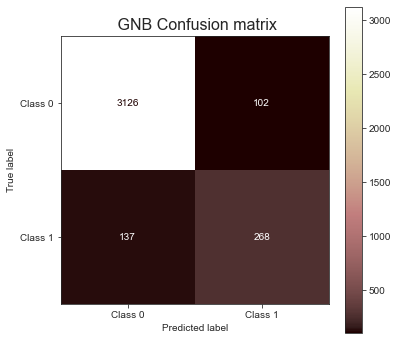

In [197]:
cnf_matrix=confusion_matrix(y_test, y_test_predict)
fig, ax = plt.subplots(figsize=(6, 6))
cm_display = ConfusionMatrixDisplay(cnf_matrix, display_labels = ['Class 0', 'Class 1'])
cm_display.plot(ax=ax, cmap=plt.cm.pink)
ax.set_title(' GNB Confusion matrix', size=16)
plt.savefig("GaussianNB confusion matrix after hyperparameter tuning")

After implementing cross-validation and grid search techniques, we remark that the **F1 score** has significantly **increased by 3%**. That's great!

If we go back and check, F1 score for our classifier Naive Bayes was 0.66. But now after selecting the best hyperparameters for our model the f1 score equals to 0.69 ~ 0.7

F1 increase is due to the improvement of precision and recall scores. As we mentionned before F1 combines this two metrics. 

## Closing thoughts

- Principal Component Analysis minimizes multicolinearity between independant features.
- Implementing oversampling methods on our imbalanced dataset helped us to handle the imbalance of our labels.
- Accuracy is not a good choice for the unbalanced classes.
- F1 on the other hand is the best choice when False Positive and False Negatives are both important.
- Oversampling the training data need to be done during cross-validation, not before.
- Hyperparameters tuning selects the optimal parameters for our model and increases metric's scores

I hope this notebook has been useful. I would be pleased to receive your feedback :)